### Loading Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
import random
import seaborn as sns

pd.set_option("display.max_column", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\hp\Downloads\WEEK 174 STATE LINELIST.csv")

#### Data Anonymization and Removing Irrelevant Columns

In [3]:
fake = Faker()

In [4]:
def anonymize_data(df):
    df['Patient_Name'] = df['Patient_Name'].apply(lambda x: fake.name())
    df['ART_ID'] = df['ART_ID'].apply(lambda x: fake.phone_number())
    df['Patient_Address'] = df['Patient_Address'].apply(lambda x: fake.address().replace('\n', ' '))
    df['Patient_LGA'] = df['Patient_LGA'].apply(lambda x: fake.address().replace('\n', ' '))
    return df

anonymized_df = anonymize_data(df)

In [5]:
anonymized_df = anonymized_df.drop(['Facility_Name', 'IP', 'Datim_Code', 'HospitalNo','Patient_LGA',
                                   'Patient_State', 'State', 'Phone_No'], axis = 1)

In [6]:
data = anonymized_df

### EDA and Data Cleaning

In [7]:
data.drop('Age_in_months', axis = 1, inplace = True)

In [8]:
data.drop('setting', axis = 1, inplace = True)

In [9]:
conv_to_datetime = ['EnrollmentDate', 'ART_Start_Date', 'ViralLoadReportedDate', 'Clinic_Visit_Lastdate', 'Pharmacy_LastPickupdate',
                    'stamp_date', 'DateofCurrentViralLoad', 'ViralLoadReportedDate', 'LastDateOfSampleCollection', 'TBStatusDate',
                    'INHStartDate',	'INHStopDate',	'LastINHDispensedDate',	'TBTreatmentStartDate',	'TBTreatmentStopDate',	
                    'OTZStartDate',	'OTZStopDate', 'DateofFirstDTGPickup', 'Termination_Date', 'Next_Visit_Date',	
                    'Next_Ap_by_pharmPill',	'Next_Ap_by_careCard', 'Biometric_date', 'Date_Generated']

for col in conv_to_datetime:
    data[col] = pd.to_datetime(data[col], errors = 'coerce')                   

In [10]:
data.drop('DOB',axis = 1, inplace = True)

In [11]:
# Convert to integer
conv_to_int = ['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'CurrentViralLoad', 'CurrentWeight_Kg', 'CurrentHeight_Kg', 'Days_To_Schedule']

for cols in conv_to_int:
    data[cols] = pd.to_numeric(data[cols], errors = 'coerce')

In [12]:
# performing a descriptive statistics
data.select_dtypes(['float', 'int']).describe()

,current_Age,Age_At_Start,DaysOfARVRefill,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_Kg,Days_To_Schedule
count,110483.000000,101373.000000,98620.000000,7.215100e+04,96096.000000,79141.000000,99003.000000
mean,37.398405,32.611070,138.558315,1.000956e+04,63.126291,163.274457,-363.611709
std,13.029286,12.066687,57.714790,4.011296e+05,15.769130,17.953361,1006.875580
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000,5.000000,-7301.000000
25%,28.000000,25.000000,90.000000,5.000000e+00,55.000000,158.000000,-37.000000
50%,36.000000,31.000000,180.000000,1.000000e+01,64.000000,165.000000,53.000000
75%,45.000000,40.000000,180.000000,1.900000e+01,72.000000,172.000000,100.000000
max,119.000000,113.000000,180.000000,1.000000e+08,250.000000,270.000000,180.000000


In [13]:
# calculate null percentage and drop columns above 50% null percentage
cols_above_50 = []
for cols in data.columns:
    null_percentage = data[cols].isnull().mean()*100
    if null_percentage > 50:
        cols_above_50.append(cols)

In [14]:
# drop these columns
data.drop(cols_above_50, axis = 1, inplace = True)

In [15]:
# categorical analysis
categorical_features = ['Sex', 'CurrentRegimenLine', 'TBStatus', 'Appointment_Status',
                       'RegimenLineAtARTStart',	'RegimenAtARTStart', 'CurrentARTRegimen', 'ViralLoadIndication', 'DTGFirstPickUp',	
                       'CurrentARTStatus',	'Biometric_Status']
for feature in categorical_features:
    print(f"{data[feature].value_counts()}\n")

Sex
F         63407
M         46355
Female      524
Male        197
Name: count, dtype: int64

CurrentRegimenLine
Adult 1st line ARV regimen     98205
Child 1st line ARV regimen      1933
Adult 2nd line ARV regimen      1208
Child 2nd line ARV regimen       100
Adult 3rd Line ARV Regimens       27
One                               24
Two                                1
Child 3rd Line ARV Regimens        1
AZT-3TC-DTG                        1
Name: count, dtype: int64

TBStatus
No signs or symptoms of disease    97519
Currently on INH prophylaxis        1460
Disease suspected                   1129
On treatment for disease             269
Completed treatment for disease      251
Disease diagnosed                    105
27-Jul-22                              1
Name: count, dtype: int64

Appointment_Status
Active With Drugs     71483
LTFU                  36481
Missed Appointment     2502
Today Visit              19
Name: count, dtype: int64

RegimenLineAtARTStart
Adult 1st line ARV regi

In [16]:
# convert categorical features to category
data[categorical_features] = data[categorical_features].astype('category')

In [17]:
# inconsistency in SEX, replace F with Female and M with Male
data['Sex'].replace({"F":'Female', 'M':'Male'}, inplace = True)

In [18]:
# rename height column
data.rename(columns={'CurrentHeight_Kg': 'CurrentHeight_cm'}, inplace=True)

In [19]:
# fill null values for numerical data.
average_female_age = data[data['Sex'] == 'Female']['Age_At_Start'].mean().round(0)
average_male_age = data[data['Sex'] == 'Male']['Age_At_Start'].mean().round(0)

In [20]:
data.loc[data['Sex'] == 'Female', 'Age_At_Start'] = data[data['Sex'] == 'Female']['Age_At_Start'].fillna(average_female_age)
data.loc[data['Sex'] == 'Male', 'Age_At_Start'] = data[data['Sex'] == 'Male']['Age_At_Start'].fillna(average_male_age)

In [21]:
data.isnull().sum()

ART_ID                            0
Sex                               2
current_Age                       2
Patient_Name                      0
Patient_Address                   0
Age_At_Start                      2
EnrollmentDate                  507
ART_Start_Date                 9111
Clinic_Visit_Lastdate          8987
Pharmacy_LastPickupdate       13083
stamp_date                    10950
DaysOfARVRefill               11865
RegimenLineAtARTStart          8985
RegimenAtARTStart              9537
CurrentRegimenLine             8985
CurrentARTRegimen             11910
CurrentViralLoad              38334
DateofCurrentViralLoad        38330
LastDateOfSampleCollection    36505
ViralLoadReportedDate         47428
ViralLoadIndication           38225
CurrentWeight_Kg              14389
CurrentWeightDate             14388
CurrentHeight_cm              31344
CurrentHeightDate             31343
TBStatus                       9751
TBStatusDate                   8972
INHStartDate                

In [29]:
data.update(data.select_dtypes('datetime64').interpolate(method='linear', axis=0))

<Axes: >

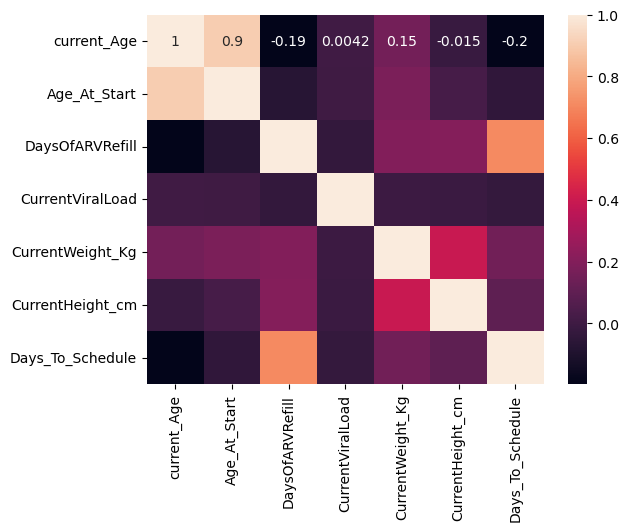

In [30]:
# Check correlation between variables
corr_matrix = data.select_dtypes(['int', 'float']).corr()
sns.heatmap(corr_matrix, annot = True)

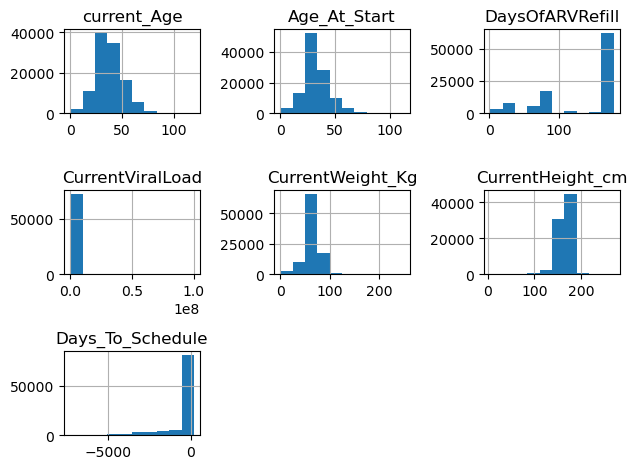

In [32]:
# check distribution for categorical variable
data.select_dtypes(['int', 'float']).hist()
plt.tight_layout()
plt.show()

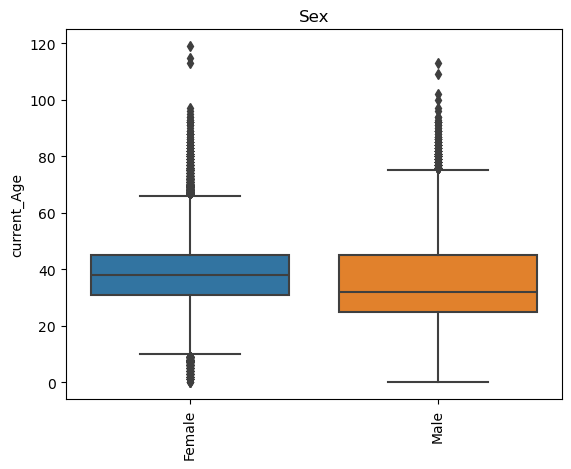

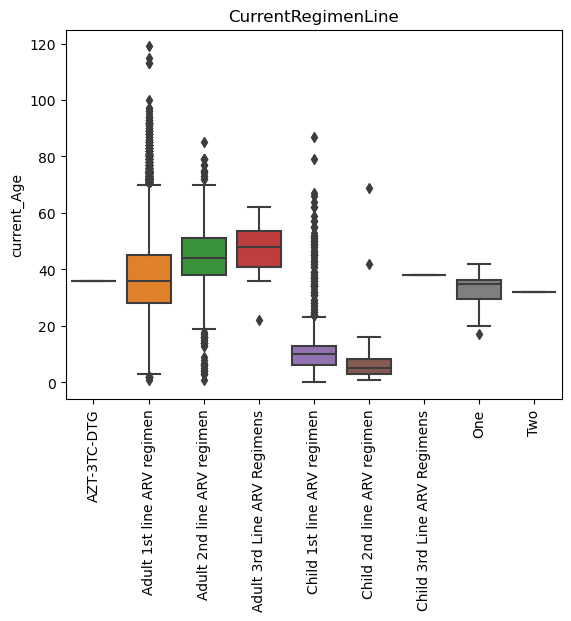

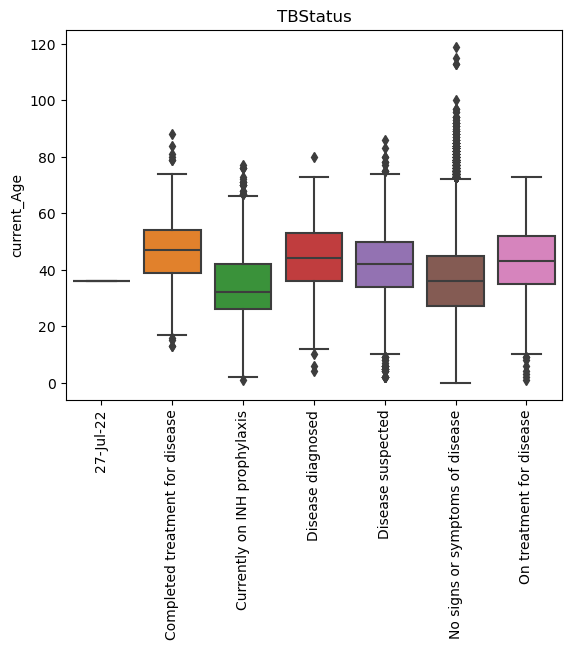

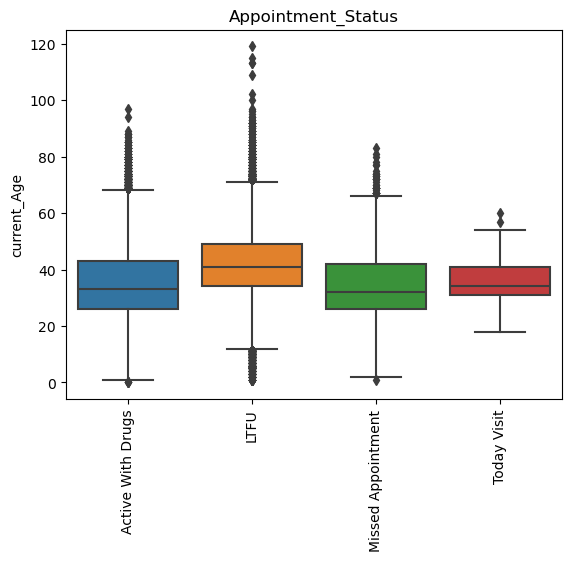

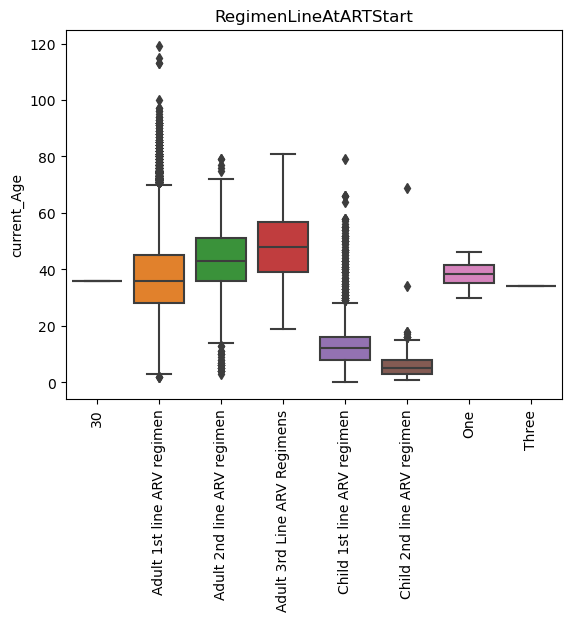

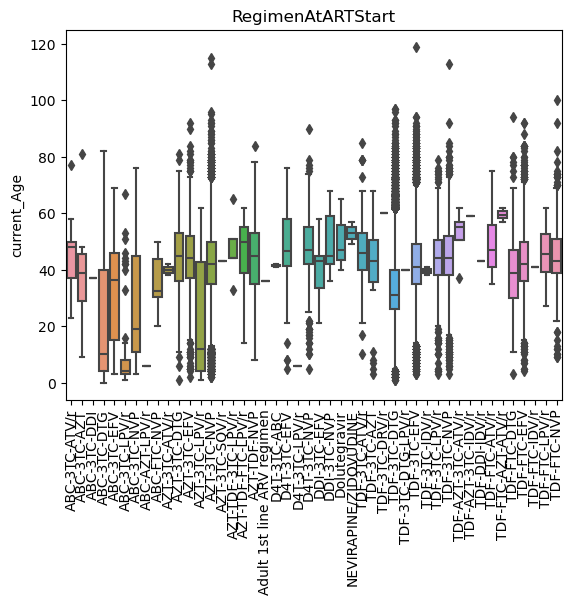

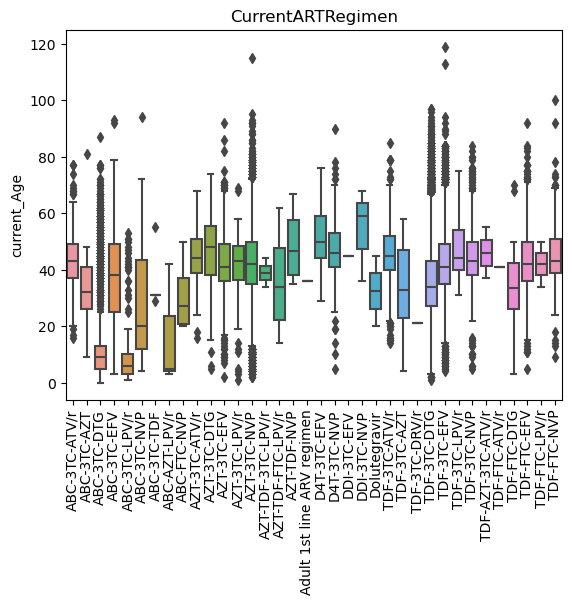

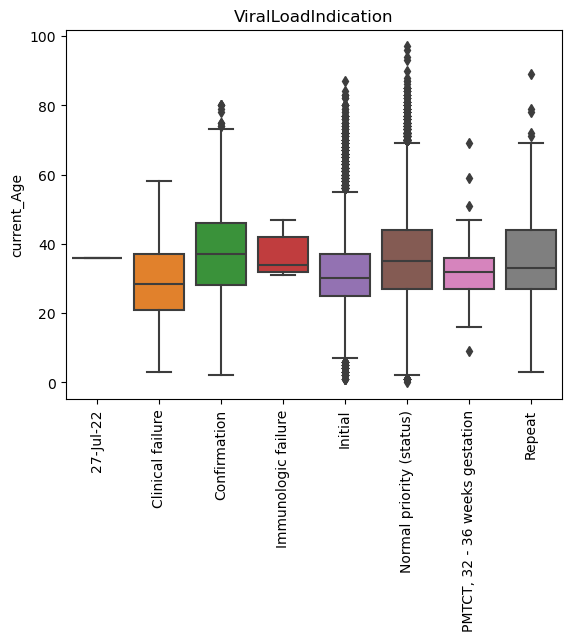

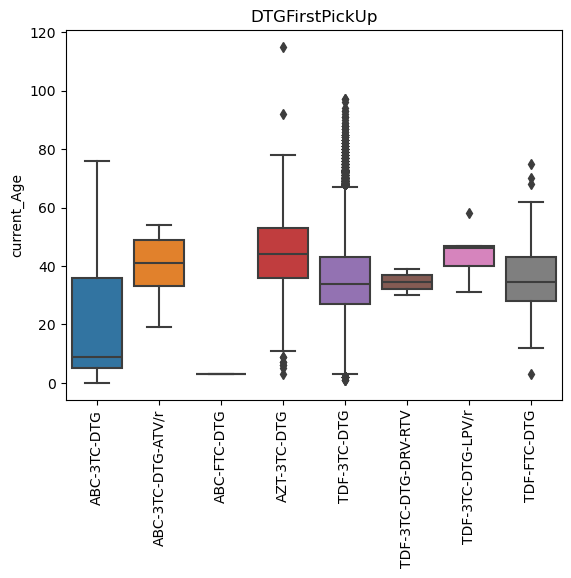

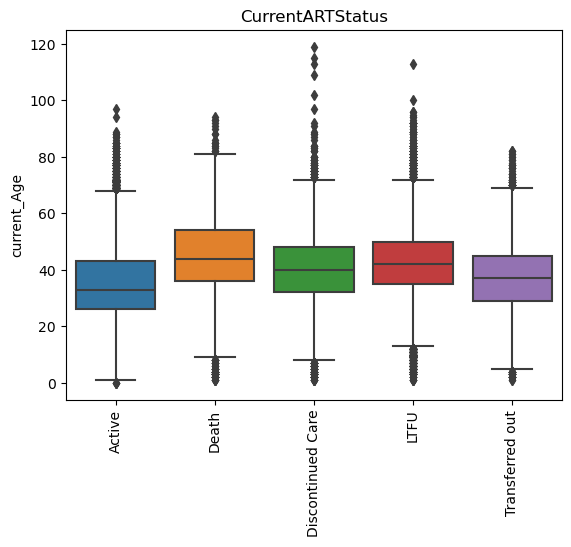

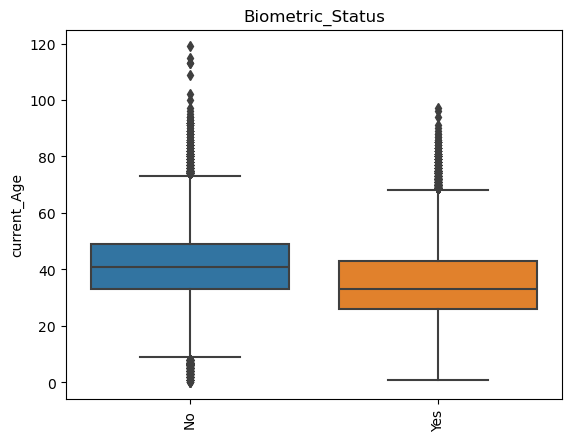

In [33]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()

In [34]:
# discovered an inconsistency and clean "27-Jul-22"
data[data['TBStatus'] == '27-Jul-22']

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,RegimenLineAtARTStart,RegimenAtARTStart,CurrentRegimenLine,CurrentARTRegimen,CurrentViralLoad,DateofCurrentViralLoad,LastDateOfSampleCollection,ViralLoadReportedDate,ViralLoadIndication,CurrentWeight_Kg,CurrentWeightDate,CurrentHeight_cm,CurrentHeightDate,TBStatus,TBStatusDate,INHStartDate,DTGFirstPickUp,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated
96353,383.709.4196,Male,36.0,Phillip White,"315 Welch Underpass Suite 255 Campostown, AR 7...",32.0,2018-08-10 12:00:00,2018-11-12,2022-05-31 12:00:00,2022-07-27,2022-08-11 02:17:00,NaN,30,Adult 1st line ARV regimen,AZT-3TC-DTG,Adult 1st line ARV regimen,NaN,2022-03-03 12:00:00,2022-07-27,2022-07-27,27-Jul-22,NaN,59,NaN,165,27-Jul-22,2022-05-31 12:00:00,2022-07-27,TDF-3TC-DTG,2018-12-03,Active,Today Visit,2022-08-26,2022-08-26,2022-08-26,0.0,Yes,2021-01-20,2022-08-26 16:34:00


In [35]:
# drop the row
data = data[data['TBStatus'] != '27-Jul-22']

In [36]:
data[data['RegimenLineAtARTStart'] == '30'] # The above code has taken care of the 30 outlier in RegimenLineAtARTStart column

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,RegimenLineAtARTStart,RegimenAtARTStart,CurrentRegimenLine,CurrentARTRegimen,CurrentViralLoad,DateofCurrentViralLoad,LastDateOfSampleCollection,ViralLoadReportedDate,ViralLoadIndication,CurrentWeight_Kg,CurrentWeightDate,CurrentHeight_cm,CurrentHeightDate,TBStatus,TBStatusDate,INHStartDate,DTGFirstPickUp,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated


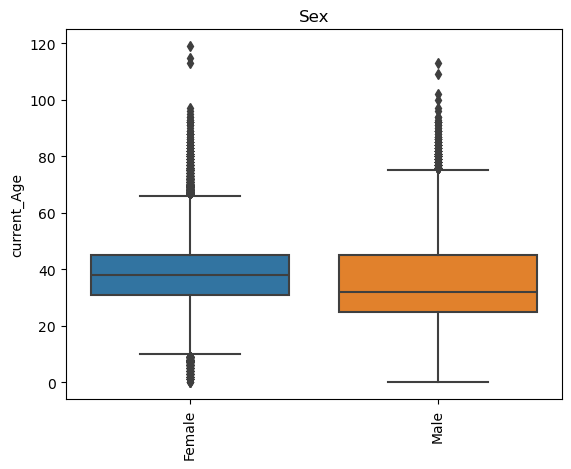

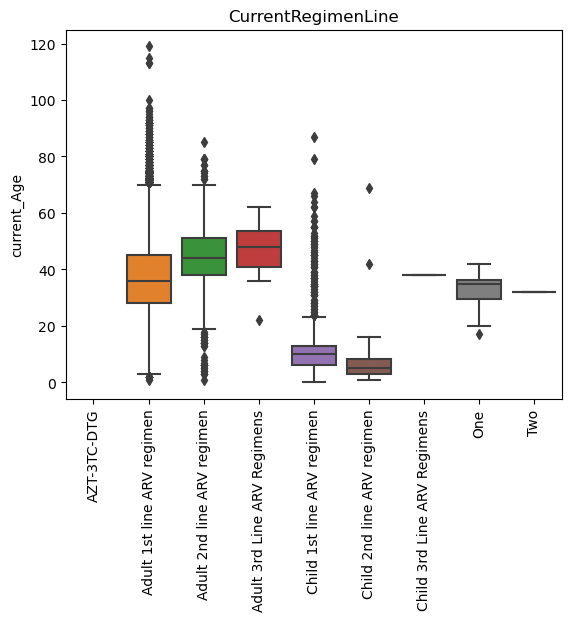

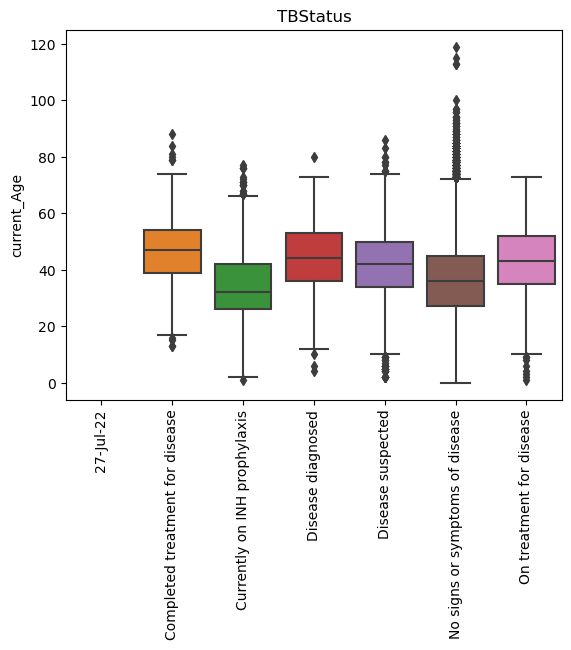

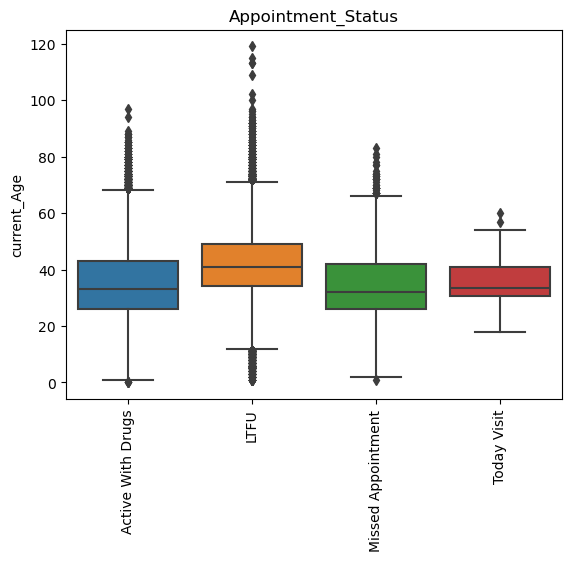

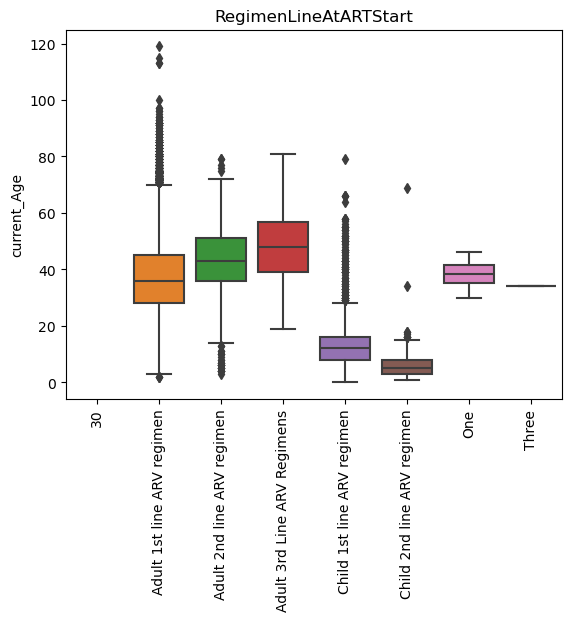

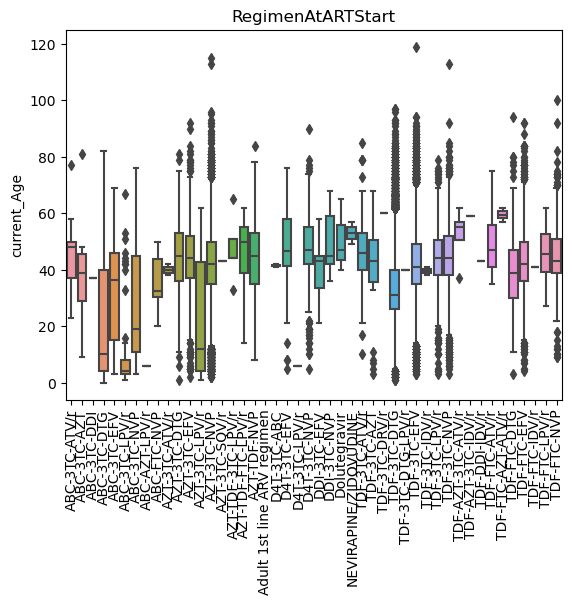

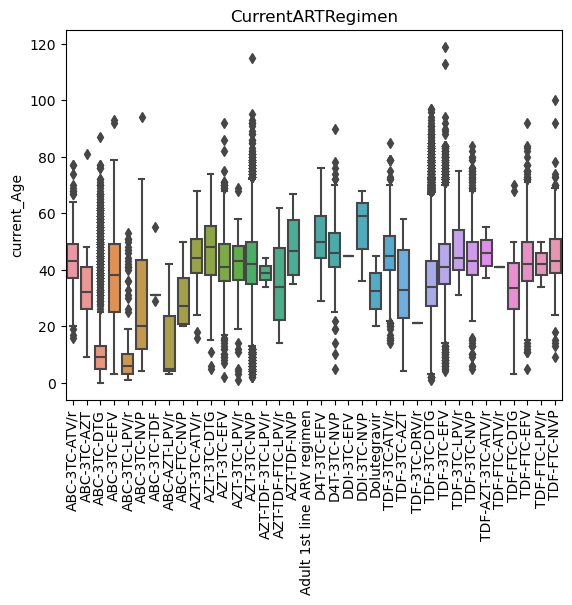

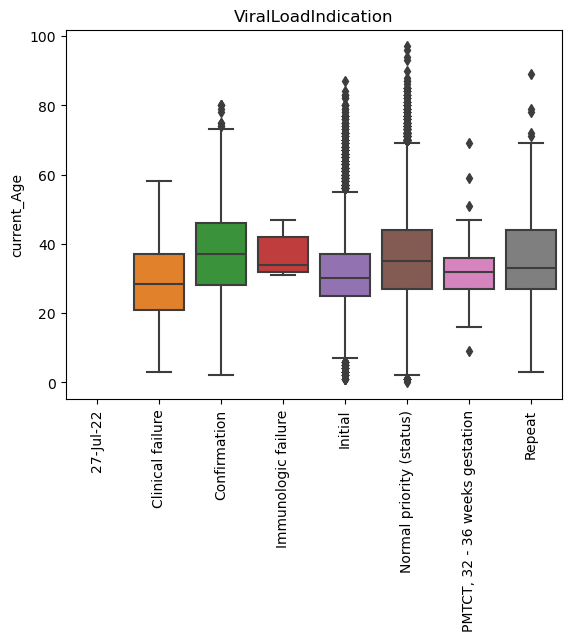

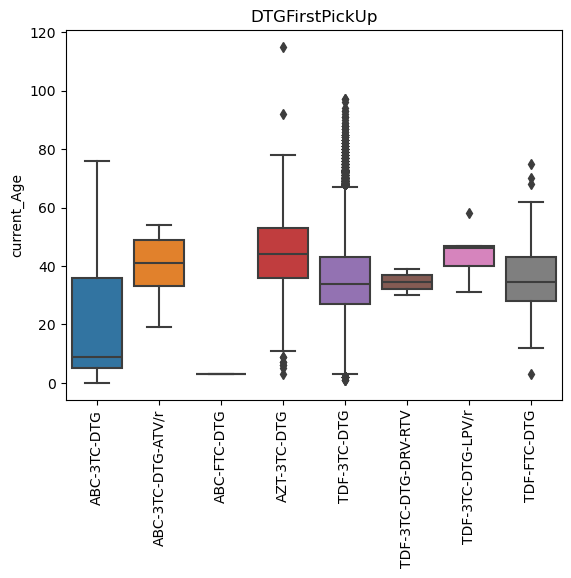

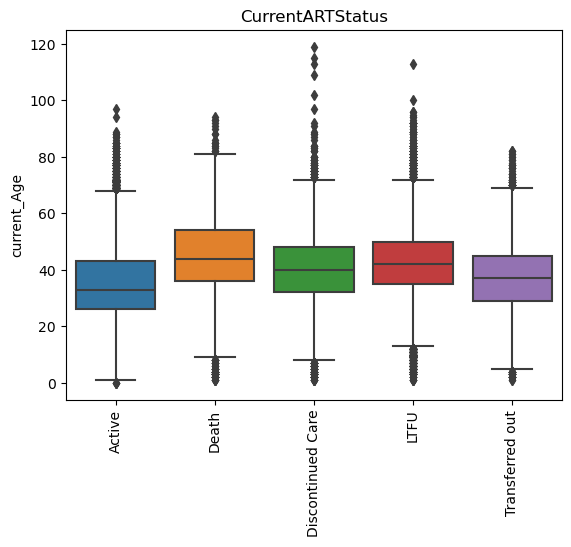

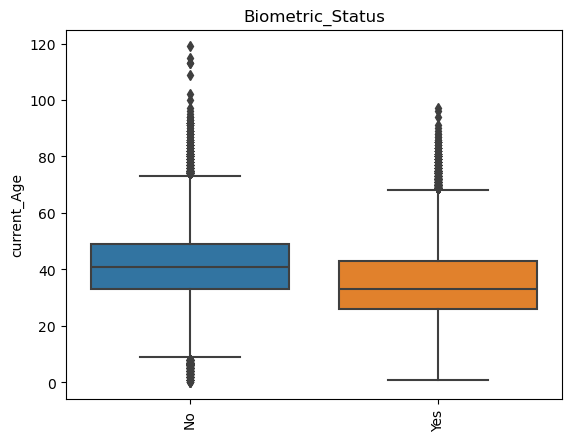

In [37]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()

### Predictive Analysis

Build a predictive model to understand and predict patients adherance to treatment.This can help healthcare industries understand patients reactions to Anti-retro viral therapy (ART), and also to understand factors that will probably affect patient response to ART treatment.

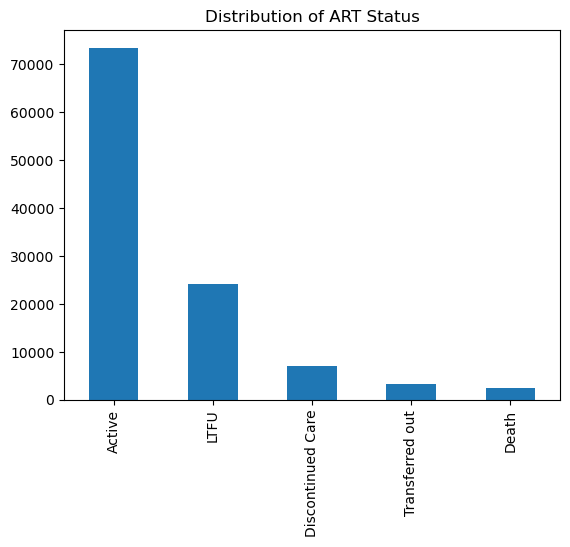

In [38]:
data['CurrentARTStatus'].value_counts().plot.bar()
plt.title('Distribution of ART Status')
plt.xlabel('')
plt.show()

### Feature Selection

In [39]:
from sklearn.feature_selection import mutual_info_regression

feature_data = data.copy()
x = feature_data
y = feature_data.pop('CurrentARTStatus')

# Encoding Categorical variables
for col in feature_data.select_dtypes(['object', 'category']):
    x[col],_ = x[col].factorize()

# Encoding y variable
y,_ = y.factorize()

<Axes: >

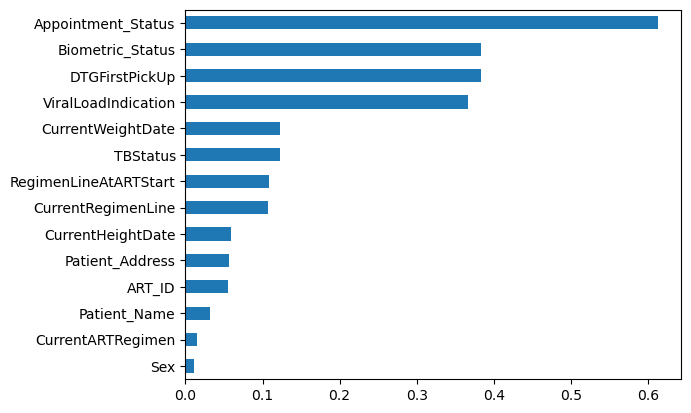

In [58]:
# Building Mutual Regression Model
x = x.select_dtypes('int64')
mi_scores = mutual_info_regression(x,y, random_state = 0)
mi_scores = pd.Series(mi_scores, index = x.columns)
best_features = mi_scores.sort_values(ascending = False).head(14)

# Show features relationship to target variable
best_features.sort_values(ascending = True).plot(kind = 'barh')

### Feature Encoding

In [41]:
# Fill null values in categorical columns with mode
for col in data.select_dtypes('category'):
    data[col] = data[col].fillna(data[col].mode().iloc[0])

In [46]:
# cardinality count
print('This counts number of unique value in the categorical variable\n')
for col in data.select_dtypes('category'):
    print(f"{col} : {data[col].value_counts().nunique()}\n")

This counts number of unique value in the categorical variable



In [123]:
from category_encoders import BinaryEncoder

In [125]:
data[1:10000].to_csv('ART prediction dataset.csv', index = False)

In [132]:
pred_data.drop(['Sex_0','Sex_1','Biometric_Status_0','Biometric_Status_1'], axis = 1, inplace = True)

In [134]:
# Encode Sex and Biometric_Status
pred_data = data
encoder = BinaryEncoder()
pred_data[['Sex_Female','Sex_Male',	'Biometric_Status_No','Biometric_Status_Yes']] = encoder.fit_transform(pred_data[['Sex', 'Biometric_Status']])

In [140]:
pred_data_encoded= pd.get_dummies(pred_data, columns=['RegimenLineAtARTStart', 'TBStatus', 'ViralLoadIndication', 'DTGFirstPickUp',
                                           'CurrentRegimenLine', 
                                           'Appointment_Status'])

In [142]:
#alculate frequency of each category
regimen_at_start_freq = pred_data_encoded['RegimenAtARTStart'].value_counts(normalize=True)
current_art_regimen_freq = pred_data_encoded['CurrentARTRegimen'].value_counts(normalize=True)

# Replace categories with frequencies
pred_data_encoded['RegimenAtARTStart'] =pred_data_encoded['RegimenAtARTStart'].map(regimen_at_start_freq)
pred_data_encoded['CurrentARTRegimen'] = pred_data_encoded['CurrentARTRegimen'].map(current_art_regimen_freq)

In [148]:
pred_data_encoded = pred_data_encoded.drop(['ART_ID', 'Patient_Name', 'Patient_Address'], axis = 1)

In [159]:
pred_data_encoded[['RegimenLineAtARTStart_0',	'RegimenLineAtARTStart_1',	'RegimenLineAtARTStart_2',	'RegimenLineAtARTStart_3',	
                   'RegimenLineAtARTStart_4',	'RegimenLineAtARTStart_5',	'RegimenLineAtARTStart_6',	'TBStatus_0',	'TBStatus_1',
                   'TBStatus_2',	'TBStatus_3',	'TBStatus_4',	'TBStatus_5',	'ViralLoadIndication_0',	'ViralLoadIndication_1',	
                   'ViralLoadIndication_2',	'ViralLoadIndication_3',	'ViralLoadIndication_4',	'ViralLoadIndication_5',	
                   'ViralLoadIndication_6',	
                   'DTGFirstPickUp_0',	'DTGFirstPickUp_1',	'DTGFirstPickUp_2',	'DTGFirstPickUp_3',	'DTGFirstPickUp_4',	'DTGFirstPickUp_5',	
                   'DTGFirstPickUp_6',	'DTGFirstPickUp_7',	'CurrentRegimenLine_0',	'CurrentRegimenLine_1',	'CurrentRegimenLine_2',	'CurrentRegimenLine_3',	
                   'CurrentRegimenLine_4',	'CurrentRegimenLine_5',	'CurrentRegimenLine_6',	'CurrentRegimenLine_7',	'Appointment_Status_0',	
                   'Appointment_Status_1',	'Appointment_Status_2',	'Appointment_Status_3'
]].replace({False:0, True:1}, inplace = True)

### Feature Engineering

In [59]:
# Extract Year and Month from datetime columns
date_columns = data.select_dtypes('datetime').columns
for col in date_columns:
    data[col+'_year'] = data[col].dt.year
    data[col+'_month'] = data[col].dt.month

In [60]:
# create weight-height ratio
data['Weight_Height_Ratio'] = data['CurrentWeight_Kg'] / data['CurrentHeight_cm']

### Model_building

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Selection
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Model Training and Evaluation
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79     14784
           1       0.40      0.38      0.39      4785
           2       0.00      0.00      0.00       490
           3       0.00      0.00      0.00       613
           4       0.00      0.00      0.00      1425

    accuracy                           0.66     22097
   macro avg       0.23      0.25      0.24     22097
weighted avg       0.58      0.66      0.62     22097

[[12824  1960     0     0     0]
 [ 2960  1825     0     0     0]
 [  304   186     0     0     0]
 [  413   200     0     0     0]
 [ 1053   372     0     0     0]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14784
           1       0.88      0.89      0.89      4785
           2       0.27      0.27      0.27       490
           3       0.32      0.31      0.32     